In [6]:
import time
import numpy as np
import matplotlib.pyplot as plt

N=100
num_bins=50

# I. Monte-Carlo for some explicit multiplicative free convolutions.

Recall that the Marchenko-Pastur law is the universal limit for singular values of Gaussian matrices. Following Marchenko and Pastur (1967)
$$ \frac{1}{2 \pi} \frac{\sqrt{(x-l)(r-x)}}{x} dx ,$$
where 
$$r = (1+\sqrt{c})^2$$
$$l = (1-\sqrt{c})^2$$
and $c$ being the scale parameter.

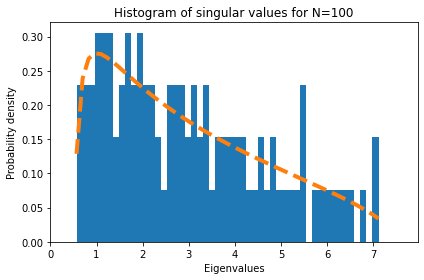

In [7]:
c = 3 # MP scale parameter
r = (1+np.sqrt(c))**2 #Right end
l = (1-np.sqrt(c))**2 #Left end

G = np.random.normal( size=(N,c*N) )
W = G.dot( G.transpose() )
W = W/N
diag, U = np.linalg.eig(W)

# Histogram of singular values
fig, ax = plt.subplots()
n, bins, patches = ax.hist(diag, num_bins, density=True)
y = np.sqrt( (r-bins)*(bins-l) )/(2*np.pi*bins)
ax.plot(bins, y, '--', linewidth=4)
ax.set_xlabel('Eigenvalues')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of singular values for N={}'.format(N))
fig.tight_layout()
plt.xlim(0,r+0.5)
plt.show()

# II. Cauchy-Stieljes transform: Empirical vs Theoretical

For convenience, let us compute:
$$ G(z) = \int_\mathbb{R} \frac{\mu_{MP}(dt)}{z-t}$$

In [48]:
def G_theoretical(z):
    sqrt = np.sqrt( (z-c-1)*(z-c-1)-4*c )
    positive_imag = (np.imag(sqrt)>0)
    sqrt = positive_imag*sqrt - (1-positive_imag)*sqrt
    #res = (z+c-1-sqrt)/(2*c*z)-2/(c*z)
    #return res*c
    return (z-c+1-sqrt)/(2*z)

def G_empirical(z):
    array = z[...,None]-diag[...,:]
    return np.sum( 1/array, axis=-1)/len(diag)

def G_prime_empirical(z):
    array = z[...,None]-diag[...,:]
    return np.sum( -1/(array*array), axis=-1)/len(diag)

def G_second_empirical(z):
    array = z[...,None]-diag[...,:]
    return np.sum( 2/(array*array*array), axis=-1)/len(diag)

def M_theoretical(z):
    return z*G_theoretical(z)-1

def M_empirical(z):
    return z*G_empirical(z)-1

def M_prime_empirical(z):
    return z*G_prime_empirical(z) + G_empirical(z)

def M_second_empirical(z):
    return z*G_second_empirical(z) + 2*G_prime_empirical(z)

z0 = np.array( complex(1.0+1.0j) )
print(z0)
print( G_theoretical(z0) )
print( G_empirical(z0) )

(1+1j)
(-0.2751252613501688-0.40867701051198535j)
(-0.27589094319574065-0.4071267889325112j)


## II. 1. Never form polynomials and never use root finding

In [9]:
# Compute critical points

# Step 1: Form polynomial
degree = len(diag)
polynomial = np.zeros( 2*(degree-1) + 1 )
print("Number of points: ", degree)
for i in range(degree):
    zeroes_without_i = np.delete( diag, i)
    double_zeroes    = np.hstack( [zeroes_without_i, zeroes_without_i] )
    polynomial = polynomial - diag[i]*np.poly(double_zeroes)/degree
# 
print("Degree of polynomial built: ", len(polynomial)-1)
print("")

# Step 2: Compute zeroes using companion matrix
critical_points = np.roots( polynomial )
print( "Critical points: ", critical_points)
print( "")


Number of points:  100
Degree of polynomial built:  198

Critical points:  [ 4.00395806e+01 +0.j          3.78115397e+01 +9.74466661j
  3.78115397e+01 -9.74466661j  3.20492297e+01+17.07328372j
  3.20492297e+01-17.07328372j  2.48928191e+01+20.88668198j
  2.48928191e+01-20.88668198j  1.82796057e+01+21.72922739j
  1.82796057e+01-21.72922739j  1.29729554e+01+20.89651811j
  1.29729554e+01-20.89651811j  9.17083180e+00+19.26383417j
  9.17083180e+00-19.26383417j  2.04351194e+01 +0.j
  1.92205317e+01 +7.50233099j  1.92205317e+01 -7.50233099j
  1.42007285e+01+14.68519226j  1.42007285e+01-14.68519226j
  7.03981207e+00+17.72339321j  7.03981207e+00-17.72339321j
  5.00537663e+00+16.820248j    5.00537663e+00-16.820248j
  3.18404208e+00+15.46673075j  3.18404208e+00-15.46673075j
  1.33253272e+01 +4.82897853j  1.33253272e+01 -4.82897853j
  1.02792865e+01+10.44432902j  1.02792865e+01-10.44432902j
  1.85983453e+00+14.05057188j  1.85983453e+00-14.05057188j
  9.29159182e-01+12.71907393j  9.29159182e-01-12.7

In [11]:
# Step 3: Check stability -- important if high degree
values = np.polyval( polynomial, critical_points )
print( "Values at roots: ")
print( values ) # VERY INSTABLE

Values at roots: 
[            -inf            +nanj              inf            +infj
              inf            -infj -1.30686855e+302+7.91298796e+302j
 -1.30686855e+302-7.91298796e+302j -4.76365704e+293-1.65958445e+293j
 -4.76365704e+293+1.65958445e+293j -2.87788861e+281-3.75173724e+282j
 -2.87788861e+281+3.75173724e+282j  6.70162748e+270+7.32290174e+269j
  6.70162748e+270-7.32290174e+269j -7.35332694e+258+1.88217111e+259j
 -7.35332694e+258-1.88217111e+259j -1.31644245e+254+0.00000000e+000j
 -6.37324016e+255-6.53951708e+255j -6.37324016e+255+6.53951708e+255j
 -2.91521040e+255-2.42494585e+255j -2.91521040e+255+2.42494585e+255j
  8.18145625e+249+1.30962505e+250j  8.18145625e+249-1.30962505e+250j
 -3.74585826e+243+4.83531930e+243j -3.74585826e+243-4.83531930e+243j
 -5.38476622e+235-1.16442364e+236j -5.38476622e+235+1.16442364e+236j
 -7.10096641e+226+1.01668350e+228j -7.10096641e+226-1.01668350e+228j
 -1.32606765e+230+2.99421823e+230j -1.32606765e+230-2.99421823e+230j
 -8.88076251e+22

### II. 2. Prefer the argument principle

Eigenvalues
min:  0.5662093064729572
max:  7.116113881738354


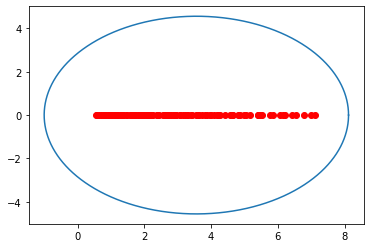

Index:  (-2.0003450302681216-0j)
Root count:  (197.99965496973186+0j)


In [61]:
print("Eigenvalues")
print("min: ", np.min(diag))
print("max: ", np.max(diag))

mesh_size = 10000
radius = np.max(diag)/2 + 1
center = np.max(diag)/2
interval = np.linspace(0, 2*np.pi, mesh_size)
contour = center + radius*( np.cos(interval) + np.sin(interval)*1.0j)
plt.scatter( np.real(diag), np.imag(diag), c='r')
plt.plot( np.real(contour), np.imag(contour) )
plt.show()

values = M_second_empirical(contour)/M_prime_empirical(contour)
#values = 1/(contour)
dz = 1.0j*(contour-center)*2*np.pi/(mesh_size) 
index  = np.sum(dz*values)/(2*np.pi*1.0j)
print( "Index: ", index)
print( "Root count: ", index+2*degree)


In [108]:
def compute_index( box, mesh_size, plot=True, color='b'):
       interval =  np.linspace( 0,1, mesh_size)
       segments = []

       s = box['bottom_right'] + interval*( box['top_right'] - box['bottom_right'] )
       segments.append( s )
       s = box['top_right'] + interval*( box['top_left'] - box['top_right'] )
       segments.append( s )
       s = box['top_left'] + interval*( box['bottom_left'] - box['top_left'] )
       segments.append( s )
       s = box['bottom_left'] + interval*( box['bottom_right'] - box['bottom_left'] )
       segments.append( s )

       integral = 0
       for s in segments:
              values = M_second_empirical(s)/M_prime_empirical(s)
              dz = ( s[-1]-s[0] )/mesh_size
              integral = integral + np.sum( values*dz )
              #
              if plot:
                     x = np.real(s)
                     y = np.imag(s)
                     plt.plot( x, y, c=color)
       return integral/(2*np.pi*1.0j)

def extend_box( box ):
       extended_box = box
       span   = extended_box['top_left']-extended_box['bottom_right']
       height = np.abs( np.imag(span) )
       width  = np.abs( np.real(span) )
       extended_box['top_right']   = extended_box['top_left']     + width
       extended_box['bottom_left'] = extended_box['bottom_right'] - width
       extended_box['height'] = height
       extended_box['width']  = width
       return extended_box

Index:  198.00005093653334
Root count:  198.0


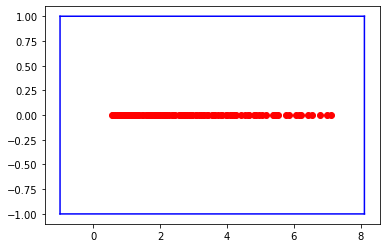

In [109]:
mesh_size = 10000
radius = 1
box = {
       'top_left'    : -1.0 + radius*1.0j,
       'bottom_right': np.max(diag) + 1 - radius*1.0j,
}
box   = extend_box(box)
index = compute_index( box, mesh_size, plot=True)
index = np.real(index+2*degree)
root_count = np.round( index )
error = index-root_count
print( "Index: ", index)
print( "Root count: ", root_count)

plt.scatter( np.real(diag), np.imag(diag), c='r')
plt.show()


Pass 0:
Index:  198.0001019062783
Root count:  198.0

Pass 1:
Index:  -4.631706687099237e-05
Root count / Total:  0 / 0

Pass 2:
Index:  2.999348045698819
Root count / Total:  3 / 3

Pass 3:
Index:  8.998205858322489
Root count / Total:  9 / 12

Pass 4:
Index:  16.81613656651882
Root count / Total:  17 / 29

Pass 5:
Index:  30.52879723886417
Root count / Total:  31 / 60

Pass 6:
Index:  23.80426682405982
Root count / Total:  24 / 84

Pass 7:
Index:  7.860677168870064
Root count / Total:  8 / 92

Pass 8:
Index:  5.477042758852047
Root count / Total:  5 / 97

Pass 9:
Index:  1.4154392049401283
Root count / Total:  1 / 98

Pass 10:
Index:  1.3179884092975727
Root count / Total:  1 / 99



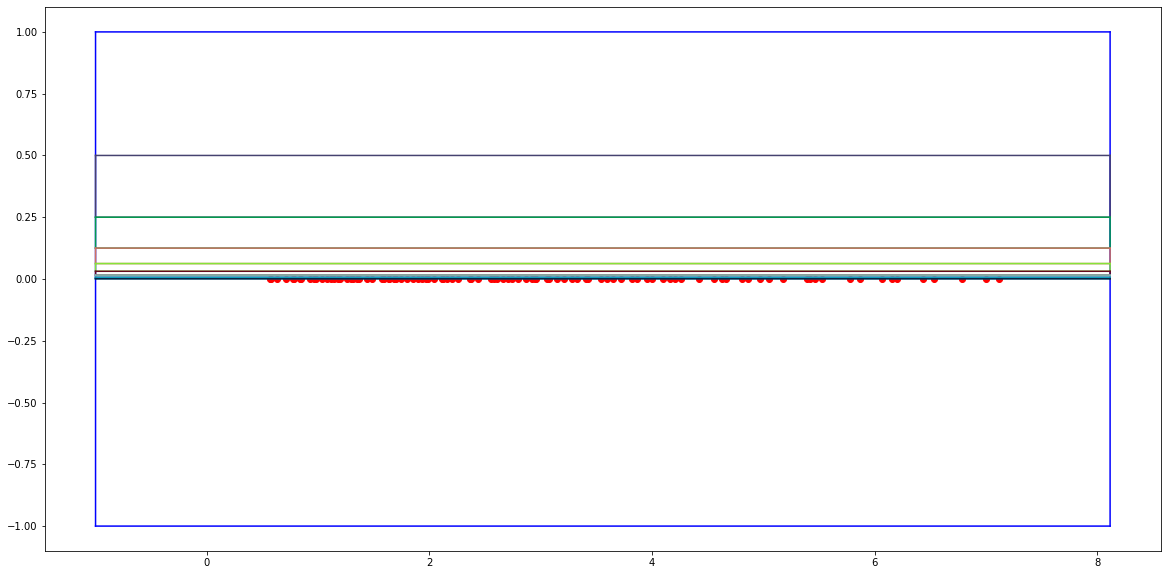

In [142]:
def plot_box( box, mesh_size, color):
    interval =  np.linspace( 0,1, mesh_size)
    segments = []

    s = box['bottom_right'] + interval*( box['top_right'] - box['bottom_right'] )
    segments.append( s )
    s = box['top_right'] + interval*( box['top_left'] - box['top_right'] )
    segments.append( s )
    s = box['top_left'] + interval*( box['bottom_left'] - box['top_left'] )
    segments.append( s )
    s = box['bottom_left'] + interval*( box['bottom_right'] - box['bottom_left'] )
    segments.append( s )

    for s in segments:
        x = np.real(s)
        y = np.imag(s)
        plt.plot( x, y, c=color)      

    return

mesh_size = 5000

plt.figure( figsize=(20,10) )

# Pass 0: Bounding box
print("Pass 0:")
radius = 1
box = {
       'top_left'    : -1.0 + radius*1.0j,
       'bottom_right': np.max(diag) + 1 - radius*1.0j,
}
box   = extend_box(box)
index = compute_index( box, mesh_size, plot=True)
index = np.real(index+2*degree)
root_count = np.round( index )
error = index-root_count
print( "Index: ", index)
print( "Root count: ", root_count)
print( "")


root_counter = 0
box['bottom_left'] = box['top_left'] # For initialization, bottom_left needs to be the previous top_left

# Loop for multiple passes and more
boxes_with_roots = []
for i in range(10):
       print(f"Pass {i+1}:")
       #print("Height: ", radius)
       radius = radius/2
       box = {
              'top_left'    : box['bottom_left'],
              'bottom_right': np.max(diag) + 1 + radius*1.0j,
       }
       box   = extend_box(box)
       index = compute_index( box, mesh_size, plot=False)
       index = np.real(index)
       root_count = int( np.round( index ) )
       root_counter = root_counter + root_count
       error = index-root_count
       print( "Index: ", index)
       print( "Root count / Total: ", root_count, '/', root_counter)
       print( "")
       #
       if root_count>0:
              box['root_count'] = root_count
              boxes_with_roots.append( box )
#

# Plotting
for box in boxes_with_roots:
       color = np.random.rand(3)
       plot_box( box, mesh_size, color)
plt.scatter( np.real(diag), np.imag(diag), c='r')
plt.show()

In [152]:
def split_box( box ):
    span = box['top_left']-box['bottom_right']
    span = ( abs(np.real(span)), abs(np.imag(span)) )
    if span[0] > span[1]:
        box1 = {
            'top_left'    : box['top_left'],
            'bottom_right': box['bottom_right']-0.5*span[0],
        }
        box2 = {
            'top_left'    : box['top_left']+0.5*span[0],
            'bottom_right': box['bottom_right'],
        }
    else:
        box1 = {
            'top_left'    : box['top_left'],
            'bottom_right': box['bottom_right']+0.5*span[1]*1.0j,
        }
        box2 = {
            'top_left'    : box['top_left']-0.5*span[1]*1.0j,
            'bottom_right': box['bottom_right'],
        }
    #
    box1 = extend_box( box1 )
    box2 = extend_box( box2 )
    return box1, box2

def refine_boxes( coarse_boxes ):
    refined_boxes = []
    for box in coarse_boxes:
        split_boxes = split_box( box )
        #
        for refined_box in split_boxes:
            index = compute_index( refined_box, mesh_size, plot=False)
            index = np.real(index)
            root_count = int( np.round( index ) )
            if root_count>0:
                refined_box['root_count'] = root_count
                refined_boxes.append( refined_box )
    return refined_boxes

refined_boxes = boxes_with_roots
print("Pass / Number of refined boxes / Total number of roots:")
for i in range(15):
    refined_boxes = refine_boxes( refined_boxes )
    counts = [ box['root_count'] for box in refined_boxes]
    print( i+1, ": ", len(refined_boxes), " / ", np.sum(counts) )

Pass / Number of refined boxes / Total number of roots:
1 :  14  /  99
2 :  23  /  99
3 :  34  /  99
4 :  51  /  99
5 :  72  /  99
6 :  82  /  99
7 :  90  /  99
8 :  98  /  99
9 :  98  /  99
10 :  99  /  99
11 :  99  /  99
12 :  99  /  99
13 :  99  /  99
14 :  99  /  99
15 :  99  /  99


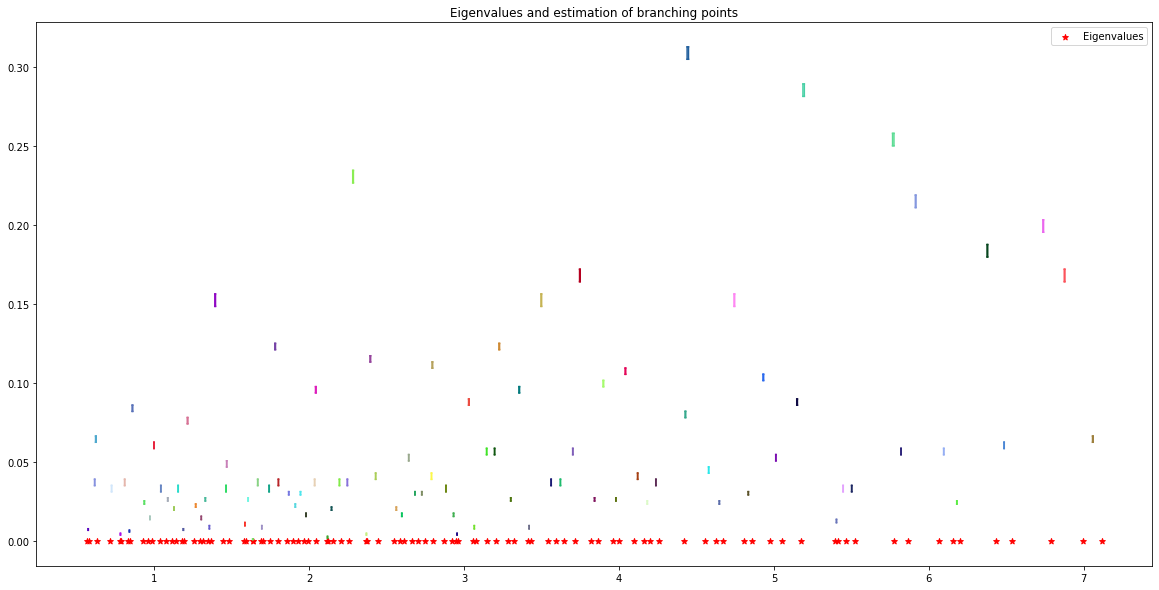

In [153]:
# Plotting
plt.figure( figsize=(20,10) )
for box in refined_boxes:
       color = np.random.rand(3)
       plot_box( box, mesh_size, color)
plt.scatter( np.real(diag), np.imag(diag), marker='*', c='r', label='Eigenvalues')
plt.title( 'Eigenvalues and estimation of branching points')
plt.legend()
plt.show()

In [ ]:
xmin = 0
xmax = 10
ymin = 0.1
ymax = 5

#Multiple passes for the number of iterations
imaginary_parts = [1.0, 0.5, 0.1, 0.001]

space_grid = np.linspace(xmin, xmax, 100)
pass_counter = 0
j       = complex(0,1)
fig = plt.figure( figsize = (12,7) )
ax = fig.add_subplot( 111 )
for y in imaginary_parts:
    start = time.time()
    # Compute
    z = np.array( space_grid + y*complex(0,1) )
    G = G_theoretical(z)
    # Statistics
    pass_counter += 1
    timing        = time.time() - start
    print ('Pass [{}/{}], Duration: {:.1f} ms' 
           .format(pass_counter, len(imaginary_parts), 1000*timing))
    print("")
    # Plot
    ax.plot(space_grid, -np.imag(G)/np.pi, '--', label="y=%.5f"%y)
    ax.set(xlabel='Space (x)', ylabel='Value',
           title='Density')
    ax.grid()
    #
    y_proxy = y
plt.ylim(0,0.3)
plt.legend()
plt.show()

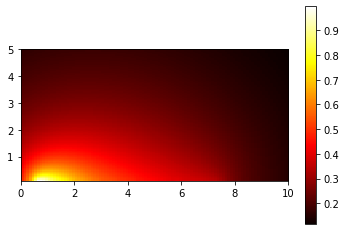

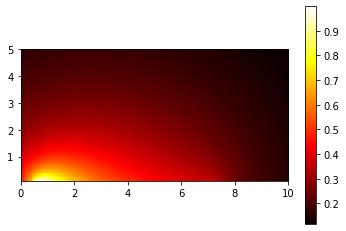

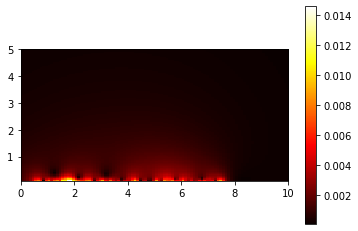

In [6]:

x = np.linspace(xmin, xmax, 100)
y = np.linspace(ymin, ymax, 100)
xv, yv = np.meshgrid(x, y)
z_grid = xv+yv*complex(1.0j)

# Empirical
G_grid = G_empirical( z_grid )
G_grid = np.flip( G_grid, axis=0)
plt.imshow( np.abs(G_grid), cmap='hot', interpolation='nearest', extent=[xmin, xmax, ymin, ymax])
plt.colorbar()
plt.show()

# Theoretical
G_grid2 = G_theoretical( z_grid )
G_grid2 = np.flip( G_grid2, axis=0)
plt.imshow( np.abs(G_grid2), cmap='hot', interpolation='nearest', extent=[xmin, xmax, ymin, ymax])
plt.colorbar()
plt.show()

# Difference
Diff = np.abs(G_grid2-G_grid)
plt.imshow( Diff, cmap='hot', interpolation='nearest', extent=[xmin, xmax, ymin, ymax])
plt.colorbar()
plt.show()

## III. Inversion (NOT DONE)

In [1]:
!pip3 install jupyterlab
!pip3 install ipympl

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable


In [7]:
%matplotlib widget

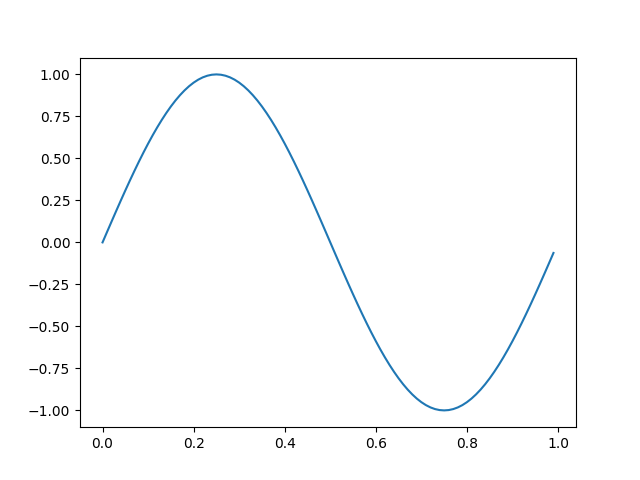

In [8]:
from matplotlib.backend_bases import MouseButton
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0.0, 1.0, 0.01)
s = np.sin(2 * np.pi * t)
fig, ax = plt.subplots()
ax.plot(t, s)


def on_move(event):
    # get the x and y pixel coords
    x, y = event.x, event.y
    if event.inaxes:
        ax = event.inaxes  # the axes instance
        print('data coords %f %f' % (event.xdata, event.ydata))


def on_click(event):
    if event.button is MouseButton.LEFT:
        print('disconnecting callback')
        plt.disconnect(binding_id)


binding_id = plt.connect('motion_notify_event', on_move)
plt.connect('button_press_event', on_click)

plt.show()